# Aphid-Ladybeetle study

## Obtaining Initial Conditions

We need to define Initial Conditions as functions in order to define them for each discretization point. Here we will fit ICs as polynomial functions.

Loading data:

In [1]:
import pandas as pd

aphid_data = pd.read_csv('../data/aphid.csv')
ladybeetle_data = pd.read_csv('../data/ladybeetle.csv')

Retrieving IC data:

In [2]:
aphid_ic_data = aphid_data[aphid_data.time == 0].copy()
ladybeetle_ic_data = ladybeetle_data[ladybeetle_data.time == 0].copy()

In [3]:
aphid_ic_data

,variable,time,x,density
0,aphid,0,1.0,19.834058
1,aphid,0,2.0,70.841565
2,aphid,0,3.0,264.045832
3,aphid,0,4.0,620.308179
4,aphid,0,5.0,434.176215
5,aphid,0,6.0,96.918214
6,aphid,0,7.0,38.285263
7,aphid,0,8.0,15.211379


In [4]:
ladybeetle_ic_data

,variable,time,x,density
0,ladybeetle,0,1.0,2.791089
1,ladybeetle,0,2.0,2.734275
2,ladybeetle,0,3.0,2.697629
3,ladybeetle,0,4.0,2.617913
4,ladybeetle,0,5.0,2.686136
5,ladybeetle,0,6.0,2.669769
6,ladybeetle,0,7.0,2.655327
7,ladybeetle,0,8.0,2.638960


### Ladybird beetles IC

For ladybird beetles is quite simple, we just need to take the mean:

In [5]:
ladybeetle_ic = ladybeetle_ic_data.density.values.mean()

ladybeetle_ic

2.6863873510629865

### Aphids IC

This is a more interesting case. Let's have a look on the points.

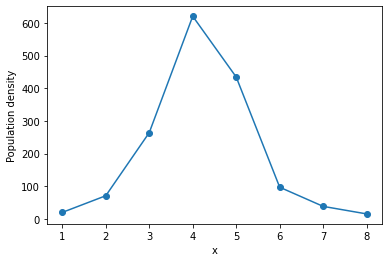

In [6]:
import matplotlib.pyplot as plt

plt.plot(aphid_ic_data.x.values, aphid_ic_data.density.values, '-o')
plt.xlabel('x')
plt.ylabel('Population density')
plt.show()

It quite resembles a gaussian. So let us fit a gaussian to it.

* Define a gaussian function:

In [7]:
import numpy as np
from typing import Union

def gaussian(
    x: Union[float, np.ndarray],
    scale_term: float,
    mu: float, 
    sigma: float
) -> Union[float, np.ndarray]:
    """
    A univariate gaussian function.
    
    :param x:
        The value to evaluate the gaussian function.
        
    :param scale_term:
        The proportional term that multiplicates the gaussian exponential
        term.
        
    :param mu:
        The mean for the gaussian function.
        
    :param sigma:
        The standard deviation.
        
    :return:
        A value, or an array of values, computed with the gaussian function.
    """
    exponential_term = np.exp(- 1.0 / 2.0 * ((x - mu) / sigma) ** 2.0)
    return scale_term * exponential_term

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [8]:
def calculate_least_squares_error(parameters, x_data, y_data, fitting_model):
    args = parameters
    y_model = fitting_model(x_data, *args)    
    residual = y_data - y_model
    return np.sum(residual ** 2.0)

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [9]:
from scipy import optimize


def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')
    

parameters_bounds = [(1e-5, 1000), (1e-5, 10), (1e-5, 1000)]
x_data = aphid_ic_data.x.values
y_data = aphid_ic_data.density.values
seed = 1234  # for the sake of reproducibility

result= optimize.differential_evolution(
    calculate_least_squares_error, 
    bounds=parameters_bounds, 
    args=(x_data, y_data, gaussian), 
    popsize=30,
    strategy='best1bin',
    tol=1e-8,
    recombination=0.7,
    maxiter=500,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
)

print(result)

differential_evolution step 1: f(x)= 355463
parameters = [195.63549367   5.37033824 643.01581751]

differential_evolution step 2: f(x)= 355451
parameters = [194.74637253   3.13392236 362.68744169]

differential_evolution step 3: f(x)= 354818
parameters = [195.29219431   4.40594159  42.91756473]

differential_evolution step 4: f(x)= 352767
parameters = [182.99086019   1.02139934  17.35647956]

differential_evolution step 5: f(x)= 350106
parameters = [214.03042632   1.80148122  15.52827362]

differential_evolution step 6: f(x)= 348893
parameters = [214.03042632   3.23636905  13.19985252]

differential_evolution step 7: f(x)= 281021
parameters = [222.70448192   3.09557883   2.39930845]

differential_evolution step 8: f(x)= 257213
parameters = [224.61756075   3.54746467   2.73455639]

differential_evolution step 9: f(x)= 257213
parameters = [224.61756075   3.54746467   2.73455639]

differential_evolution step 10: f(x)= 257213
parameters = [224.61756075   3.54746467   2.73455639]

different

* Retrieving the calibrated parameter values:

In [10]:
scale_term, mu, sigma = result.x

x = np.linspace(0, 9)
aphid_ic_points = gaussian(x, scale_term, mu, sigma)

* Plotting the fitted function to compare with data:

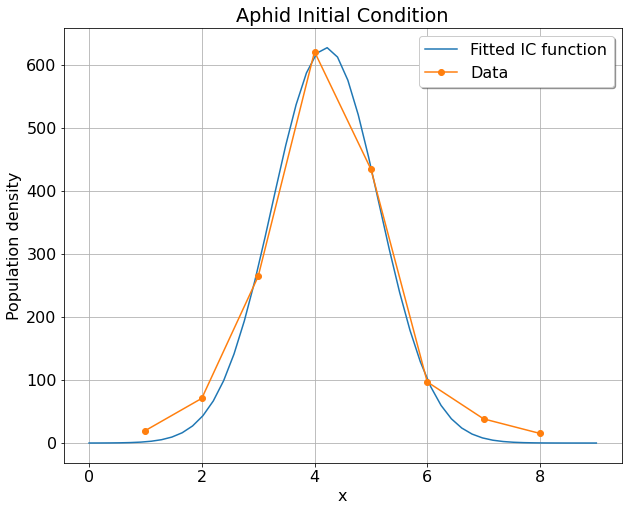

In [11]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})

plt.plot(x, aphid_ic_points, '-', label='Fitted IC function')
plt.plot(aphid_ic_data.x.values, aphid_ic_data.density.values, '-o', label='Data')

plt.title('Aphid Initial Condition')
plt.xlabel('x')
plt.ylabel('Population density')

plt.grid(True)
plt.legend(fancybox=True, shadow=True)

plt.savefig('fitted_ic.png', dpi=300)
plt.show()

## First model: classical Lotka-Volterra

The problem consists in solving the system:

\begin{equation}
\begin{aligned}
u_{t} &=D_{u} u_{x x}+f(u, v) \\
v_{t} &=D_{v} v_{x x}+g(u, v)
\end{aligned}
\end{equation}

in which $u$ is the prey and $v$ the predator, $D_u$ and $D_v$ are the diffusive coefficients, and $f(u, v)$ and $g(u, v)$ are the reactive terms that can have the following form:

\begin{equation}
\begin{array}{c}
f(u, v)=r u-a u v \\
g(u, v)=b a u v-m v
\end{array}
\end{equation}

with the constants $r, a, b, m > 0$.


In [12]:
from pde import (PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid, 
                 CartesianGrid, MemoryStorage)
from pde import ExplicitSolver, ImplicitSolver, Controller, ScipySolver

# Species diffusivity coefficients (please be careful with this values)
Du = 1e-6
Dv = 1e-4  # predator assumed to be faster than prey

# Rate coefficients
r = 0.15
a = 0.2
b = 1.02  # Let's predator population increases when they prey because life is not easy
m = 0.05

# Functional response
f_function = f"+ {r} * u - {a} * u * v"  # don't forget to put + (or -) sign in the beginning
g_function = f"+ {b} * {a} * u * v - {m} * v"

# (Dirichlet) Boundary condition example
bc_left = {"value": 0.0}  # both unknowns are set to zero, unfortunately
bc_right = {"value": 0.0}
bc = [bc_left, bc_right]

# Definition of PDE system
eq = PDE(
    {
        "u": f"{Du} * laplace(u)" + f_function,
        "v": f"{Dv} * laplace(v)" + g_function,
    },
    bc=bc  # comment here if you want to "free" the boundaries
)

# Defining the mesh
num_points_in_x = 100
grid = CartesianGrid(bounds=[[0, 1]], shape=num_points_in_x)

# Initialize state (Initial Conditions)
u = ScalarField.from_expression(grid, "sin(pi * x)", label="Prey")
# v = ScalarField.from_expression(grid, "abs(sin(2 * pi * x))", label="Predator")
v = ScalarField.from_expression(grid, "0.1", label="Predator")
# v = ScalarField(grid, 0.1, label="Predator")
state = FieldCollection([u, v])  # state vector

# Define time tracker to plot and animate
x_axis_limits = (0, 1)
y_axis_limits = (0, 3.5)
tracker_plot_config = PlotTracker(show=True, plot_args={
        'ax_style': {'xlim': x_axis_limits, 'ylim': y_axis_limits},
    }
)
storage = MemoryStorage()
trackers = [
    "progress",  # show progress bar during simulation
    "steady_state",  # abort if steady state is reached
    storage.tracker(interval=1),  # store data every simulation time unit
    tracker_plot_config,  # show images during simulation
]

# Setup explicit solver
# explicit_solver = ExplicitSolver(eq)
# controller = Controller(explicit_solver, t_range=[0, 100], tracker=trackers)
# solve = controller.run(state, dt=1e-2)

# Setup scipy solver
scipy_solver = ScipySolver(eq, method='LSODA')
controller = Controller(scipy_solver, t_range=[0, 100], tracker=trackers)
solve = controller.run(state, dt=1e-2)

Spent more time on handling trackers (68.65678733500005) than on the actual simulation (2.318516714999957)


In [13]:
u_storage = storage.extract_field(0)
v_storage = storage.extract_field(1)

u_storage.data

[array([0.01570732, 0.04710645, 0.0784591 , 0.10973431, 0.14090123,
        0.1719291 , 0.2027873 , 0.23344536, 0.26387305, 0.29404033,
        0.32391742, 0.35347484, 0.38268343, 0.41151436, 0.43993917,
        0.46792981, 0.49545867, 0.52249856, 0.54902282, 0.57500525,
        0.60042023, 0.62524266, 0.64944805, 0.67301251, 0.6959128 ,
        0.7181263 , 0.73963109, 0.76040597, 0.78043041, 0.79968466,
        0.81814972, 0.83580736, 0.85264016, 0.86863151, 0.88376563,
        0.89802758, 0.91140328, 0.92387953, 0.93544403, 0.94608536,
        0.95579301, 0.96455742, 0.97236992, 0.97922281, 0.98510933,
        0.99002366, 0.99396096, 0.99691733, 0.99888987, 0.99987663,
        0.99987663, 0.99888987, 0.99691733, 0.99396096, 0.99002366,
        0.98510933, 0.97922281, 0.97236992, 0.96455742, 0.95579301,
        0.94608536, 0.93544403, 0.92387953, 0.91140328, 0.89802758,
        0.88376563, 0.86863151, 0.85264016, 0.83580736, 0.81814972,
        0.79968466, 0.78043041, 0.76040597, 0.73